# Forcasting  

In this notebook we will predict the closing prices for the next month

In [ ]:
"""# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from copy import deepcopy

# Load the dataset
data = pd.read_csv('./data/cleaned_weekly_stock_market.csv')


# Extract rows for specified companies
companies = ['AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE', 'EURO-CYCLES',
             'SOTUMAG', 'ONE TECH', 'SAH', 'SFBT', 'SOMOCER', 'SOTETEL',
             'SOTUVER', 'TUNISAIR', 'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB']

data_filtered = data[data['companyName'].isin(companies)]

def str_to_datetime(s):
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except ValueError:
        return datetime.strptime(s, '%d/%m/%Y')
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while not last_time:
        # Select the subset of data up to and including the target date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        # Extract closing prices as features (X) and target (Y)
        values = df_subset['closingPrice'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Attempt to move to the next date within a week
        next_week = dataframe.loc[target_date + timedelta(days=1):target_date + timedelta(days=7)]
        if not next_week.empty:
            next_date = next_week.index[0]
        else:
            print("No more data available for the next week.")
            break

        # Update target_date
        target_date = next_date

        # Check if the process should terminate
        if target_date >= last_date:
            last_time = True

    # Prepare the return DataFrame
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y

    return ret_df


def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
    y = df_as_np[:, -1]
    return dates, X.astype(np.float32), y.astype(np.float32)

def train_and_plot_model(data, company_name):
    try:
        print(f"Starting process for {company_name}...")
        n = 3 
        df = data[['date', 'closingPrice']]
        df['date'] = df['date'].apply(str_to_datetime) 
        df.index = df.pop('date')
        
        first_valid_date = df.index[n]
        last_date = df.index[-1]
        windowed_df = df_to_windowed_df(df, first_valid_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'), n=n)
        
        if windowed_df is None:
            print("Windowed dataframe is None, exiting...")
            return

        dates, X, y = windowed_df_to_date_X_y(windowed_df)

        print("Splitting data into train, validation, and test sets...")
       # Define the split indices
        q_10 = int(len(dates) * 0.1)
        q_20 = int(len(dates) * 0.2)

        # Split the data
        dates_test, X_test, y_test = dates[:q_10], X[:q_10], y[:q_10]
        dates_val, X_val, y_val = dates[q_10:q_20], X[q_10:q_20], y[q_10:q_20]
        dates_train, X_train, y_train = dates[q_20:], X[q_20:], y[q_20:]


        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, y_train, label='Train')
        plt.plot(dates_val, y_val, label='Validation')
        plt.plot(dates_test, y_test, label='Test')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Train, Validation, and Test Data for {company_name}')
        plt.show()

        model = Sequential([layers.Input(shape=(n, 1)),
                            layers.LSTM(64),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(1)])
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])
        model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

        train_pred = model.predict(X_train).flatten()
        val_pred = model.predict(X_val).flatten()
        test_pred = model.predict(X_test).flatten()

        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, train_pred)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_pred)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_pred)
        plt.plot(dates_test, y_test)
        plt.legend(['Training Prediction', 'Training Observation',
                    'Validation Prediction', 'Validation Observation',
                    'Test Prediction', 'Test Observation'])
        plt.title(f'Predictions and Observations for {company_name}')
        plt.show()

        # Recursive predictions
        print("Starting recursive predictions...")
        recursive_predictions = []
        recursive_dates = np.concatenate([dates_val, dates_test])

        last_window = deepcopy(X_train[-1])
        for target_date in recursive_dates: 
            next_pred = model.predict(np.array([last_window])).flatten()
            recursive_predictions.append(next_pred)
            last_window = np.roll(last_window, -1)
            last_window[-1] = next_pred
            
        recursive_predictions = np.array(recursive_predictions).flatten()
        plt.figure(figsize=(19, 6))
        plt.plot(dates_train, train_pred)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_pred)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_pred)
        plt.plot(dates_test, y_test)
        plt.plot(recursive_dates, recursive_predictions)
        plt.legend(['Training Predictions', 
                    'Training Observations',
                    'Validation Predictions', 
                    'Validation Observations',
                    'Testing Predictions', 
                    'Testing Observations',
                    'Recursive Predictions'])
        plt.title(f'Recursive Predictions for {company_name}')
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


# Apply the model for each company
for company in companies:
    company_data = data_filtered[data_filtered['companyName'] == company]
    if not company_data.empty:
        print(f'Training and plotting for {company}')
        train_and_plot_model(company_data, company)
    else:
        print(f'No data available for {company}')
"""

In [1]:
# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from copy import deepcopy

In [2]:
# Load the dataset
data = pd.read_csv('./data/cleaned_weekly_stock_market.csv')

In [3]:
# Extract rows for specified companies
companies = ['AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE', 'EURO-CYCLES',
             'SOTUMAG', 'ONE TECH', 'SAH', 'SFBT', 'SOMOCER', 'SOTETEL',
             'SOTUVER', 'TUNISAIR', 'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB']

data_filtered = data[data['companyName'].isin(companies)]

In [4]:
def str_to_datetime(s):
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except ValueError:
        return datetime.strptime(s, '%d/%m/%Y')

In [5]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while not last_time:
        # Select the subset of data up to and including the target date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        # Extract closing prices as features (X) and target (Y)
        values = df_subset['closingPrice'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Attempt to move to the next date within a week
        next_week = dataframe.loc[target_date + timedelta(days=1):target_date + timedelta(days=7)]
        if not next_week.empty:
            next_date = next_week.index[0]
        else:
            print("No more data available for the next week.")
            break

        # Update target_date
        target_date = next_date

        # Check if the process should terminate
        if target_date >= last_date:
            last_time = True

    # Prepare the return DataFrame
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y

    return ret_df

In [6]:
def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
    y = df_as_np[:, -1]
    return dates, X.astype(np.float32), y.astype(np.float32)

In [7]:
def train_and_plot_model(data, company_name):
    try:
        print(f"Starting process for {company_name}...")
        n = 3 
        df = data[['date', 'closingPrice']]
        df['date'] = df['date'].apply(str_to_datetime) 
        df.index = df.pop('date')
        
        first_valid_date = df.index[n]
        last_date = df.index[-1]
        windowed_df = df_to_windowed_df(df, first_valid_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'), n=n)
        
        if windowed_df is None:
            print("Windowed dataframe is None, exiting...")
            return

        dates, X, y = windowed_df_to_date_X_y(windowed_df)

        # Normalize the data
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X.reshape(-1, 1)).reshape(-1, n, 1)
        y = scaler.transform(y.reshape(-1, 1)).flatten()

        print("Splitting data into train, validation, and test sets...")
        # Define the split indices
        q_10 = int(len(dates) * 0.1)
        q_20 = int(len(dates) * 0.2)

        # Split the data
        dates_test, X_test, y_test = dates[:q_10], X[:q_10], y[:q_10]
        dates_val, X_val, y_val = dates[q_10:q_20], X[q_10:q_20], y[q_10:q_20]
        dates_train, X_train, y_train = dates[q_20:], X[q_20:], y[q_20:]

        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)), label='Train')
        plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)), label='Validation')
        plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)), label='Test')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Train, Validation, and Test Data for {company_name}')
        plt.show()

        model = Sequential([layers.Input(shape=(n, 1)),
                            layers.LSTM(64),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(1)])
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])
        model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

        train_pred = model.predict(X_train).flatten()
        val_pred = model.predict(X_val).flatten()
        test_pred = model.predict(X_test).flatten()

        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, scaler.inverse_transform(train_pred.reshape(-1, 1)))
        plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)))
        plt.plot(dates_val, scaler.inverse_transform(val_pred.reshape(-1, 1)))
        plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)))
        plt.plot(dates_test, scaler.inverse_transform(test_pred.reshape(-1, 1)))
        plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)))
        plt.legend(['Training Prediction', 'Training Observation',
                    'Validation Prediction', 'Validation Observation',
                    'Test Prediction', 'Test Observation'])
        plt.title(f'Predictions and Observations for {company_name}')
        plt.show()

        # Recursive predictions
        print("Starting recursive predictions...")
        recursive_predictions = []
        recursive_dates = np.concatenate([dates_val, dates_test])

        last_window = deepcopy(X_train[-1])
        for target_date in recursive_dates:
            next_pred = model.predict(np.array([last_window])).flatten()
            recursive_predictions.append(next_pred)
            last_window = np.roll(last_window, -1)
            last_window[-1] = next_pred

        recursive_predictions = np.array(recursive_predictions).flatten()
        recursive_predictions = scaler.inverse_transform(recursive_predictions.reshape(-1, 1)).flatten()
        plt.figure(figsize=(19, 6))
        plt.plot(dates_train, scaler.inverse_transform(train_pred.reshape(-1, 1)))
        plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)))
        plt.plot(dates_val, scaler.inverse_transform(val_pred.reshape(-1, 1)))
        plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)))
        plt.plot(dates_test, scaler.inverse_transform(test_pred.reshape(-1, 1)))
        plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)))
        plt.plot(recursive_dates, recursive_predictions)
        plt.legend(['Training Predictions', 
                    'Training Observations',
                    'Validation Predictions', 
                    'Validation Observations',
                    'Testing Predictions', 
                    'Testing Observations',
                    'Recursive Predictions'])
        plt.title(f'Recursive Predictions for {company_name}')
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

Training and plotting for AMEN BANK
Starting process for AMEN BANK...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


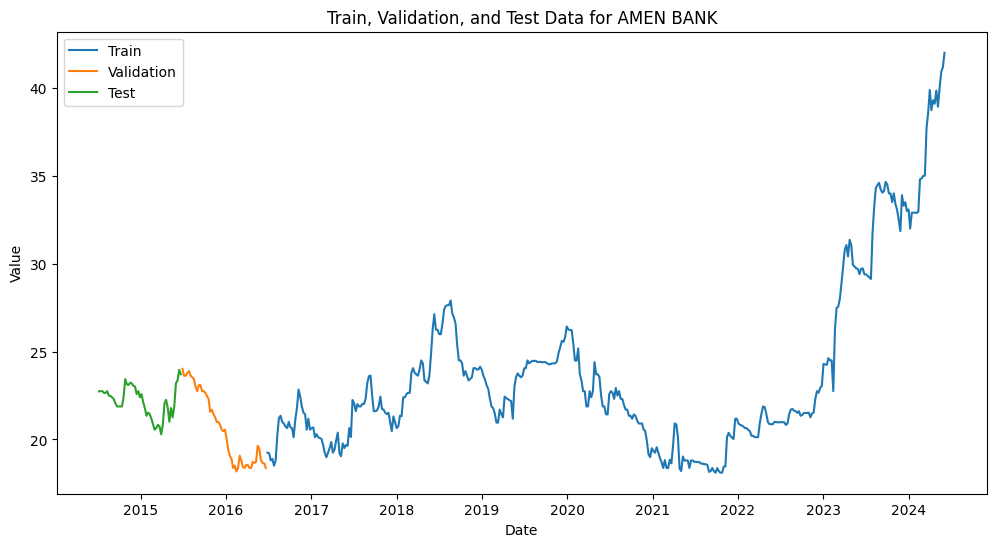

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0890 - mean_absolute_error: 0.2241 - val_loss: 0.0066 - val_mean_absolute_error: 0.0679
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0464 - mean_absolute_error: 0.1379 - val_loss: 0.0092 - val_mean_absolute_error: 0.0805
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216 - mean_absolute_error: 0.1092 - val_loss: 0.0151 - val_mean_absolute_error: 0.1161
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - mean_absolute_error: 0.0857 - val_loss: 0.0022 - val_mean_absolute_error: 0.0404
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0339 - val_loss: 3.0778e-04 - val_mean_absolute_error: 0.0144
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - mean_absolute_error: 0.0290 - val_loss: 4.1814e-04 - val_mean_absolute_error: 0.0175
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0

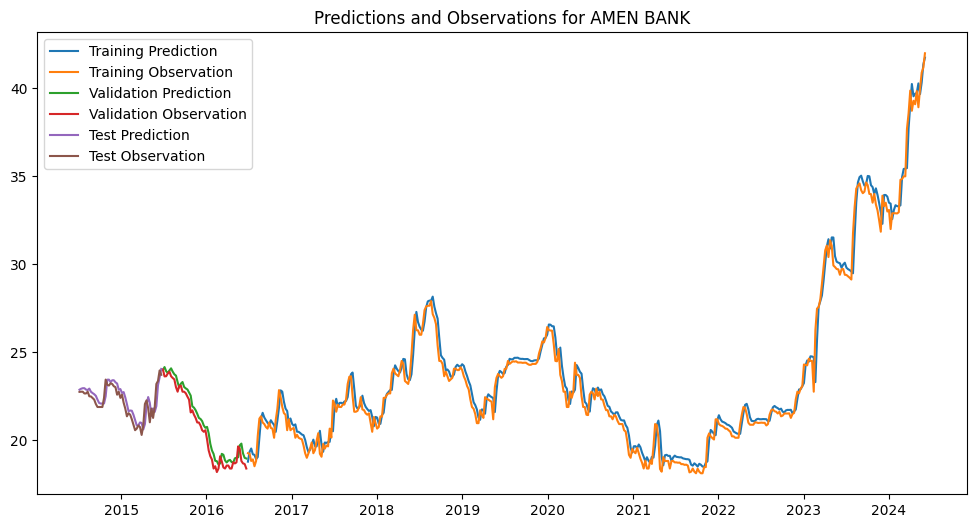

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━

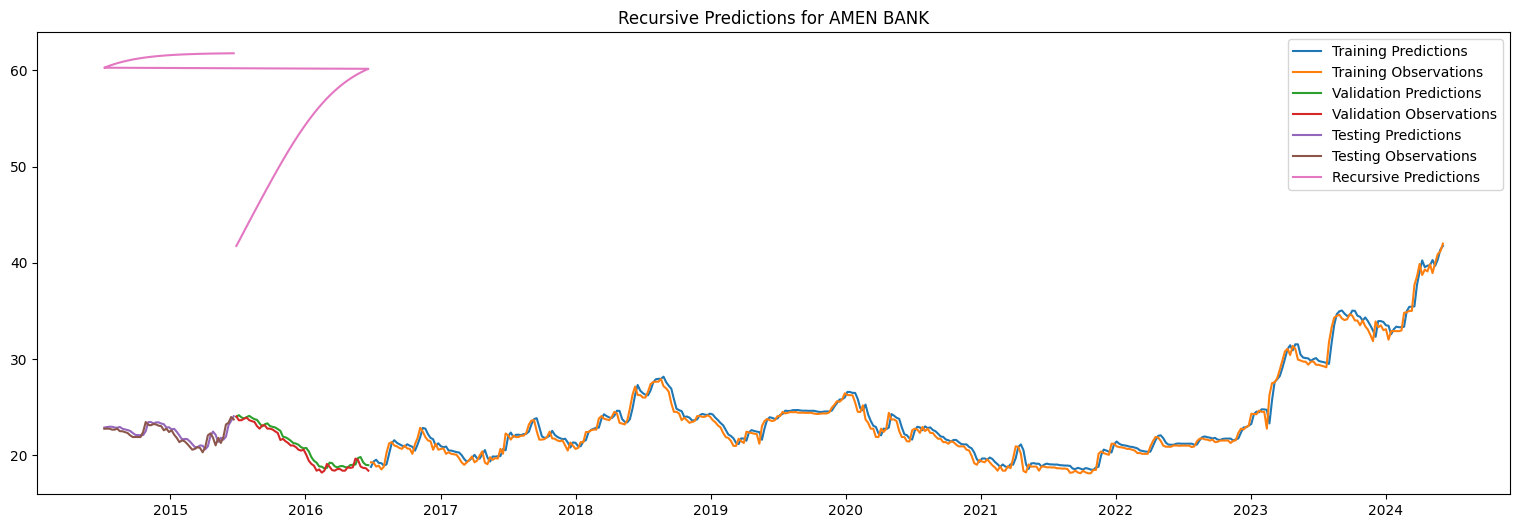

Training and plotting for ARTES
Starting process for ARTES...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


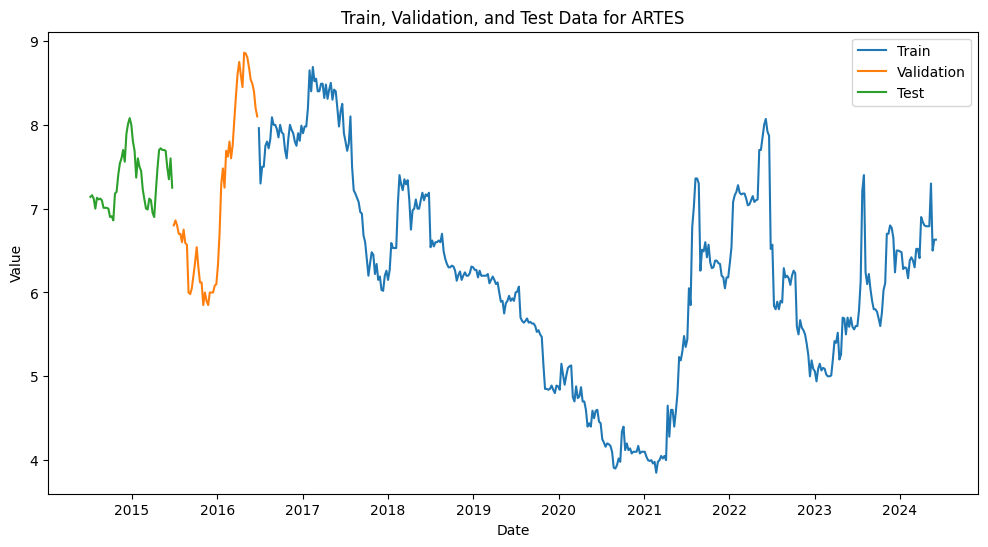

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2205 - mean_absolute_error: 0.4156 - val_loss: 0.2309 - val_mean_absolute_error: 0.4489
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0852 - mean_absolute_error: 0.2416 - val_loss: 0.0249 - val_mean_absolute_error: 0.1206
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - mean_absolute_error: 0.0989 - val_loss: 0.0120 - val_mean_absolute_error: 0.0857
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - mean_absolute_error: 0.0821 - val_loss: 0.0056 - val_mean_absolute_error: 0.0609
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_absolute_error: 0.0644 - val_loss: 0.0062 - val_mean_absolute_error: 0.0590
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0423 - val_loss: 0.0046 - val_mean_absolute_error: 0.0501
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0398 - val_lo

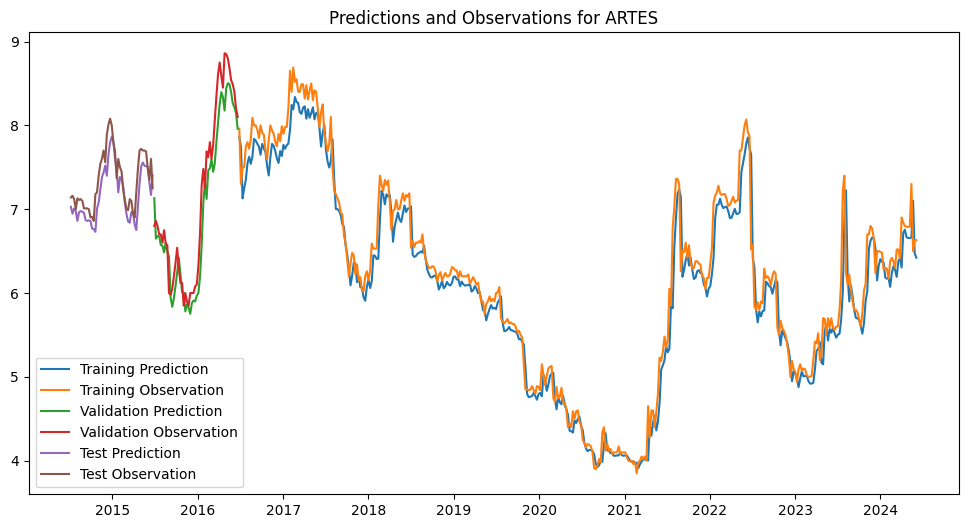

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━

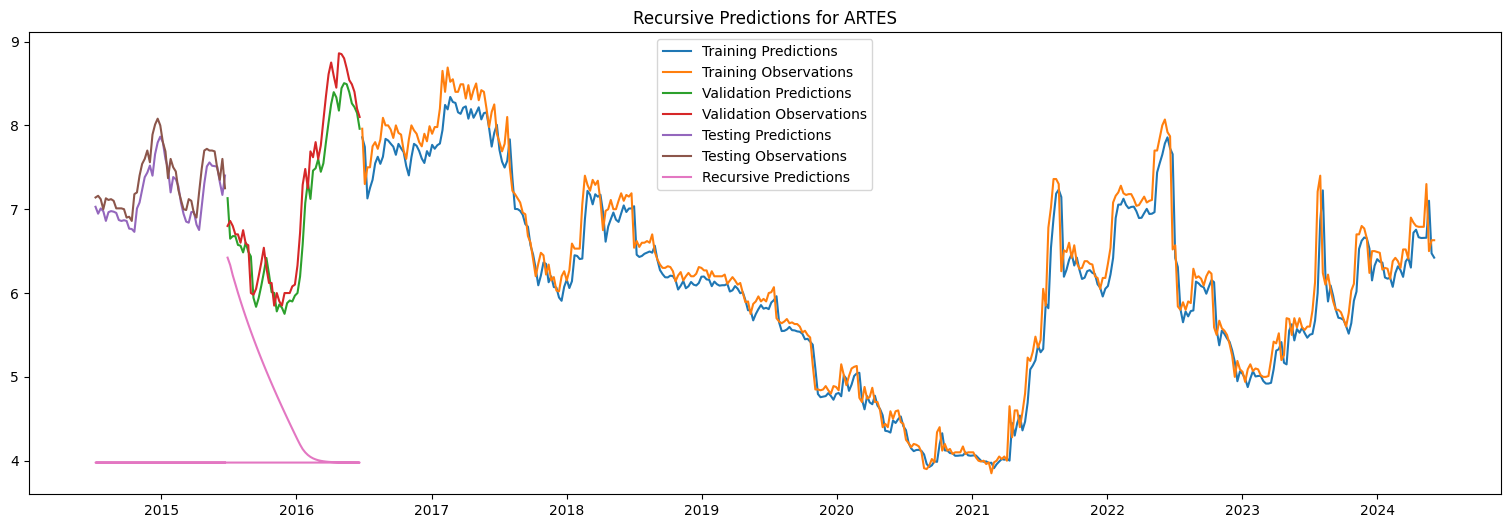

Training and plotting for ASSAD
Starting process for ASSAD...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


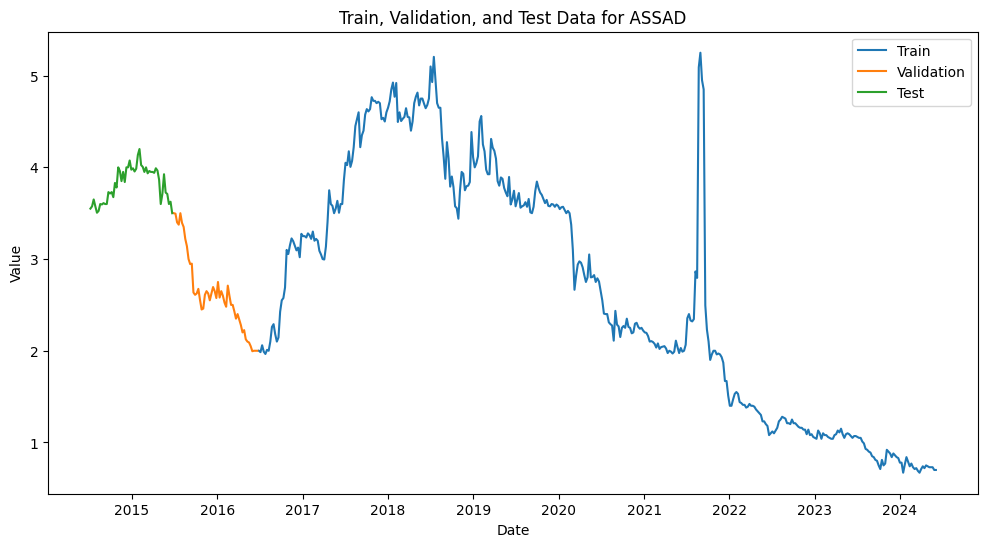

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.2411 - mean_absolute_error: 0.3976 - val_loss: 0.0987 - val_mean_absolute_error: 0.3037
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1145 - mean_absolute_error: 0.2648 - val_loss: 0.0118 - val_mean_absolute_error: 0.0923
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0301 - mean_absolute_error: 0.1465 - val_loss: 0.0087 - val_mean_absolute_error: 0.0886
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - mean_absolute_error: 0.0974 - val_loss: 0.0016 - val_mean_absolute_error: 0.0341
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0506 - val_loss: 5.3727e-04 - val_mean_absolute_error: 0.0169
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0297 - val_loss: 4.8084e-04 - val_mean_absolute_error: 0.0158
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0266 -

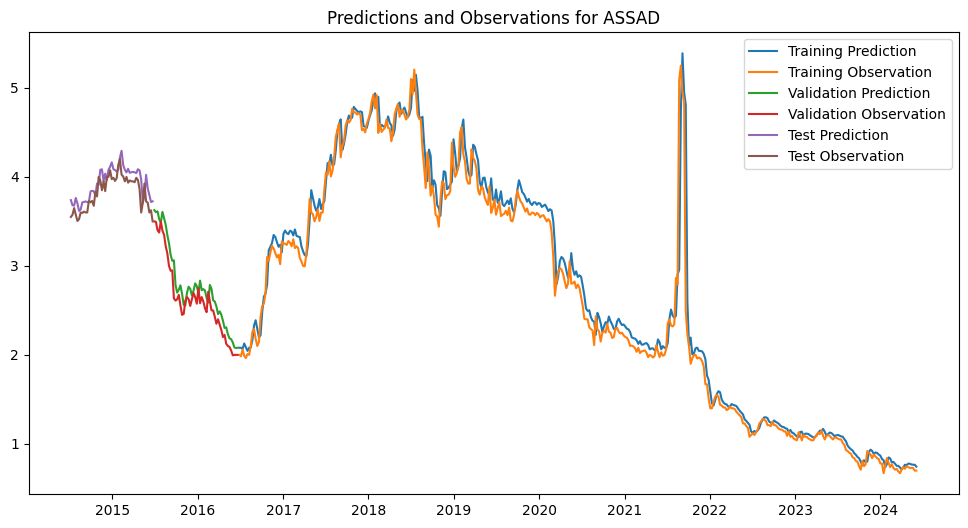

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━

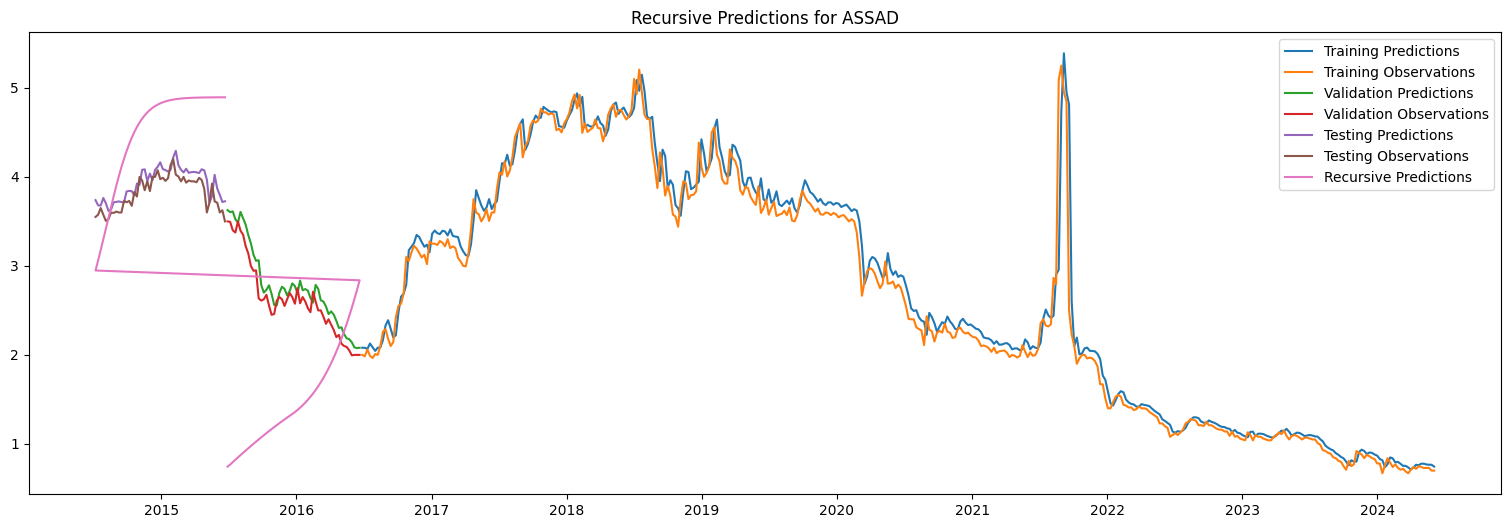

Training and plotting for BIAT
Starting process for BIAT...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


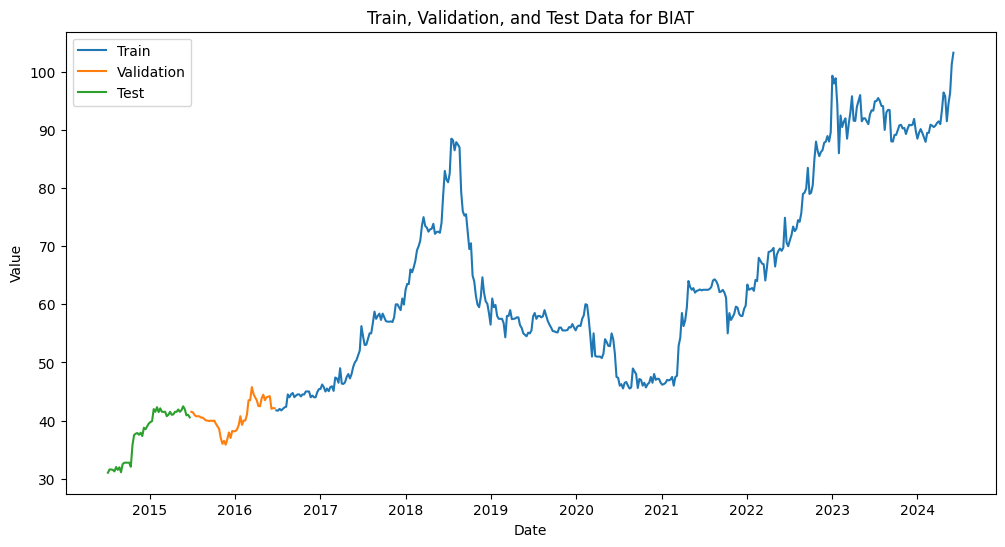

Epoch 1/100


In [8]:
# Apply the model for each company
for company in companies:
    company_data = data_filtered[data_filtered['companyName'] == company]
    if not company_data.empty:
        print(f'Training and plotting for {company}')
        train_and_plot_model(company_data, company)
    else:
        print(f'No data available for {company}')